In [3]:
import pandas as pd
import os
import numpy as np
import gzip
from scipy.spatial import distance
from transformers import AutoTokenizer
from tqdm.notebook import trange, tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
d_dir = "./data/en-cola/"
subset = "test.csv"
model_path_tr = "./roberta-large-cased-en-cola_32_2e-05_lr_0.0001_decay_balanced/"
model_path_nt = "./roberta-large-cased-en-cola_32_2e-05_lr_0.0001_decay_balanced_frozen/"

In [5]:
data = pd.read_csv(d_dir+subset)

In [6]:
output_dir=model_path_tr
adj_filenames = [
    output_dir + 'attentions/' + filename 
    for filename in os.listdir(output_dir + 'attentions/') 
        if subset.split(".")[0] + '_part' in (output_dir + 'attentions/' + filename) and '.npy' in filename]
# sorted by part number
adj_filenames = sorted(adj_filenames, key = lambda x: int(x.split('_')[-1].split('of')[0][4:].strip())) 
adj_filenames

['./roberta-large-cased-en-cola_32_2e-05_lr_0.0001_decay_balanced/attentions/test_part1of1.npy.gz']

In [7]:
output_dir=model_path_nt
adj_filenames_nt = [
    output_dir + 'attentions/' + filename 
    for filename in os.listdir(output_dir + 'attentions/') 
        if subset.split(".")[0] + '_part' in (output_dir + 'attentions/' + filename) and '.npy' in filename
]
adj_filenames_nt = sorted(adj_filenames_nt, key = lambda x: int(x.split('_')[-1].split('of')[0][4:].strip())) 
adj_filenames_nt

['./roberta-large-cased-en-cola_32_2e-05_lr_0.0001_decay_balanced_frozen/attentions/test_part1of1.npy.gz']

In [8]:
def load_matrix(filepath):
    loaded_adj=[]
    if 'gz' in filepath:
        with gzip.GzipFile(filepath, 'rb') as f:
            loaded_adj=np.load(f, allow_pickle=True)
    else:
        loaded_adj=np.load(filepath)
    return loaded_adj

In [9]:
if len(adj_filenames) > 1:
    tr_adj = np.concatenate((load_matrix(adj_filenames[0]), load_matrix(adj_filenames[1])), axis=0)
    nt_adj = np.concatenate((load_matrix(adj_filenames_nt[0]), load_matrix(adj_filenames_nt[1])), axis=0)
else:
    tr_adj = load_matrix(adj_filenames[0])
    nt_adj = load_matrix(adj_filenames_nt[0])
n_samples = tr_adj.shape[0]

In [10]:
cola_gr_major = pd.read_csv(d_dir + "phenomenon_minor.tsv", sep='\t')
cola_gr_major = cola_gr_major[cola_gr_major['Sentence'].isin(data.sentence.values)]
cola_gr_major = cola_gr_major.reset_index(drop=True)

In [11]:
df=cola_gr_major
tokenizer = AutoTokenizer.from_pretrained(model_path_tr)

In [12]:
def get_token_length(batch_texts):
    inputs = tokenizer.batch_encode_plus(batch_texts,
       return_tensors='pt',
       add_special_tokens=True,
       max_length=64,             # Max length to truncate/pad
       pad_to_max_length=True,         # Pad sentence to max length
       truncation=True
    )
    inputs = inputs['input_ids'].numpy()
    n_tokens = []
    indexes = np.argwhere(inputs == tokenizer.pad_token_id)
    for i in range(inputs.shape[0]):
        ids = indexes[(indexes == i)[:, 0]]
        if not len(ids):
            n_tokens.append(max_length)
        else:
            n_tokens.append(ids[0, 1])
    return n_tokens

In [13]:
ntokens_array = get_token_length(list(data['sentence'].values))

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
def cutoff_matrix(matrix, ntokens):
    """Return normalized submatrix of first n_tokens"""
    matrix = matrix[:ntokens]
    matrix /= matrix.sum()
    return matrix

In [15]:
from scipy.special import rel_entr
def jensenshannon_divergence(p, q, base=None, *, axis=0, keepdims=False):
    """
    Compute the Jensen-Shannon distance (metric) between
    two probability arrays. This is the square root
    of the Jensen-Shannon divergence.
    The Jensen-Shannon distance between two probability
    vectors `p` and `q` is defined as,
    .. math::
       \\sqrt{\\frac{D(p \\parallel m) + D(q \\parallel m)}{2}}
    where :math:`m` is the pointwise mean of :math:`p` and :math:`q`
    and :math:`D` is the Kullback-Leibler divergence.
    This routine will normalize `p` and `q` if they don't sum to 1.0.
    Parameters
    ----------
    p : (N,) array_like
        left probability vector
    q : (N,) array_like
        right probability vector
    base : double, optional
        the base of the logarithm used to compute the output
        if not given, then the routine uses the default base of
        scipy.stats.entropy.
    axis : int, optional
        Axis along which the Jensen-Shannon distances are computed. The default
        is 0.
        .. versionadded:: 1.7.0
    keepdims : bool, optional
        If this is set to `True`, the reduced axes are left in the
        result as dimensions with size one. With this option,
        the result will broadcast correctly against the input array.
        Default is False.
        .. versionadded:: 1.7.0
    Returns
    -------
    js : double or ndarray
        The Jensen-Shannon distances between `p` and `q` along the `axis`.
    Notes
    -----
    .. versionadded:: 1.2.0
    Examples
    --------
    >>> from scipy.spatial import distance
    >>> import numpy as np
    >>> distance.jensenshannon([1.0, 0.0, 0.0], [0.0, 1.0, 0.0], 2.0)
    1.0
    >>> distance.jensenshannon([1.0, 0.0], [0.5, 0.5])
    0.46450140402245893
    >>> distance.jensenshannon([1.0, 0.0, 0.0], [1.0, 0.0, 0.0])
    0.0
    >>> a = np.array([[1, 2, 3, 4],
    ...               [5, 6, 7, 8],
    ...               [9, 10, 11, 12]])
    >>> b = np.array([[13, 14, 15, 16],
    ...               [17, 18, 19, 20],
    ...               [21, 22, 23, 24]])
    >>> distance.jensenshannon(a, b, axis=0)
    array([0.1954288, 0.1447697, 0.1138377, 0.0927636])
    >>> distance.jensenshannon(a, b, axis=1)
    array([0.1402339, 0.0399106, 0.0201815])
    """
    p = np.asarray(p)
    q = np.asarray(q)
    p = p / np.sum(p, axis=axis, keepdims=True)
    q = q / np.sum(q, axis=axis, keepdims=True)
    m = (p + q) / 2.0
    left = rel_entr(p, m)
    right = rel_entr(q, m)
    left_sum = np.sum(left, axis=axis, keepdims=keepdims)
    right_sum = np.sum(right, axis=axis, keepdims=keepdims)
    js = left_sum + right_sum
    if base is not None:
        js /= np.log(base)
    return js

In [17]:
all_data=dict()
arr=[]
for features in ['Sem  Violation', "Infl/Agr Violation", "Extra/Mising Expr", "Correct", 'Syntax', 'All']:
    inds=data[data['label']==1].index[:150]
    all_data[features]=[]
    if features not in {'Correct', 'All', 'Syntax'}:
        inds=cola_gr_major[cola_gr_major[features]==1].index
        inds = [i for i in list(inds) if i in df[df['Acceptability']==0].index]
        arr.extend(list(inds))
    if features == "Syntax":
        syntax_ph = df.drop(arr)
        inds = syntax_ph[syntax_ph['Acceptability']==0].index
    if features == "All":
        inds = data.index
    distances_layers=[]
    for layer in trange(tr_adj.shape[1]):
        for sentence in inds:
            ntokens=ntokens_array[sentence]
            for head in range(tr_adj.shape[2]):
                av_words=[]
                for word in range(ntokens):
                    tr_ex = tr_adj[sentence,layer,head,:][word]
                    tr_ex = cutoff_matrix(tr_ex, ntokens) 
                    nt_ex = nt_adj[sentence,layer,head,:][word]
                    nt_ex = cutoff_matrix(nt_ex, ntokens) 
                    distance_=jensenshannon_divergence(tr_ex, nt_ex)
                    # zero arrays case 
                    if abs(distance_)!=np.inf:
                        av_words.append(distance_)
                    else:
                        if np.isnan(distance_):
                            print(tr_ex, nt_ex, distance_)
                        av_words.append(0)
            av_heads = np.mean(np.array(av_words))
        av_sents = np.mean(av_heads)
        distances_layers.append(np.mean(av_sents))
    all_data[features]=distances_layers

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

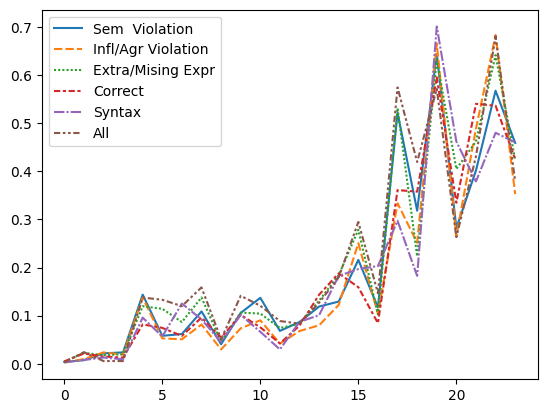

In [19]:
data_plot_dist=pd.DataFrame.from_dict(all_data)
# data_plot_dist.to_csv("en-roberta-js-test.csv")
sns.lineplot(data=data_plot_dist)
plt.show()